# Flow Matching and Diffusion Models: A 1D Tutorial

From Guanya: I always believe that the best way to learn ML algorithm is to create a Jupyter notebook including algorithms, implementations for 1D toy problems, and the visualization of results. With the help of cursor, I wrote this notebook, which provides a simple introduction of flow matching and diffusion model through simple 1D examples.

## Table of Contents

1. [Environment Setup](#setup)

### Chapter 1: Flow Matching
2. [Mathematical Foundations](#flow-math)
3. [Understanding Flow Matching](#flow-understanding)
4. [Visualization](#flow-viz)
5. [Learning Neural Networks](#flow-learning)
6. [Examples and Applications](#flow-examples)

### Chapter 2: Diffusion Models
7. [Mathematical Foundations](#diffusion-math)
8. [Visualization](#diffusion-viz)
9. [Learning Neural Networks](#diffusion-learning)
10. [Examples and Applications](#diffusion-examples)

### Chapter 3: Comparison
11. [Comparison and Analysis](#comparison)

## 1. Environment Setup {#setup}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import torch
import torch.nn as nn
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(2025)
torch.manual_seed(2025)

print("Environment setup complete!")

Environment setup complete!


# Chapter 1: Flow Matching

## 2. Mathematical Foundations {#flow-math}

### Flow Matching Theory

Flow matching is a generative modeling approach that learns to transform a simple distribution (like Gaussian) into a complex target distribution through continuous flows. It learns a vector field $v_t(x)$ that defines how to transform a simple distribution $p_0(x)$ (e.g., Gaussian) into a target distribution $p_1(x)$ (e.g., data distribution). 

### Key Concepts:
- **Flow Paths**: Direct paths from noise to data points
- **Velocity Field**: Defines how to move from one distribution to another
- **Continuous Time**: Works in continuous time rather than discrete steps
- **Optimal Transport**: Finds the most efficient way to transport mass between distributions

#### Key Equations:

**1. Flow Path (the Simple Cononical Form):**
$$x_t = (1-t) \cdot x_0 + t \cdot x_1$$

where:
- $x_0 \sim p_0(x)$ (noise)
- $x_1 \sim p_1(x)$ (data)
- $t \in [0,1]$ (time)

**2. Velocity Field:**
$$v_t(x) = \frac{dx_t}{dt} = x_1 - x_0$$

**3. Flow Matching Loss:**
$$\mathcal{L}_{FM} = \mathbb{E}_{t,x_0,x_1} \|v_\theta(x_t, t) - v_t(x)\|^2 = \mathbb{E}_{t,x_0,x_1} \|v_\theta(x_t, t) - (x_1 - x_0)\|^2$$

**4. Sampling (ODE Integration):**
$$\frac{dx}{dt} = v_\theta(x, t)$$

### Intuition:
- We learn a vector field that points from each point in the noise distribution toward the data distribution
- The flow is continuous and deterministic
- We can sample by integrating the learned vector field

### Magic Part:
- No "data pairing" between $x_0$ and $x_1$!

## 3. Understanding Flow Matching {#flow-understanding}

In [2]:
class SimpleFlowMatching1D:
    """A simple 1D flow matching implementation."""
    
    def __init__(self, num_timesteps=1000):
        self.num_timesteps = num_timesteps
        self.timesteps = np.linspace(0, 1, num_timesteps)
    
    def sample_conditional_flow(self, x0, x1, t):
        """Sample from the conditional flow path."""
        # Linear interpolation: x_t = (1-t) * x_0 + t * x_1
        x_t = (1 - t) * x0 + t * x1
        
        # Velocity field: v_t = x_1 - x_0
        v_t = x1 - x0
        
        return x_t, v_t
    
    def sample_timestep(self, batch_size=1000):
        """Sample random timesteps for training."""
        return np.random.uniform(0, 1, batch_size)

# Create a simple target distribution (mixture of Gaussians)
def create_target_distribution(n_samples=10000):
    """Create a mixture of two Gaussians as our target distribution."""
    # Mix two Gaussians: 80% at x=-2, 20% at x=2
    samples1 = np.random.normal(-2, 0.5, int(0.8 * n_samples))
    samples2 = np.random.normal(2, 0.5, int(0.2 * n_samples))
    return np.concatenate([samples1, samples2])

# Initialize flow matching model
flow_matching = SimpleFlowMatching1D()
target_data = create_target_distribution()

print(f"Flow matching model initialized with {flow_matching.num_timesteps} timesteps")
print(f"Target distribution created with {len(target_data)} samples")

Flow matching model initialized with 1000 timesteps
Target distribution created with 10000 samples


## 4. Visualization {#flow-viz}
Let's visualize how flow matching works by showing the flow paths and velocity fields.

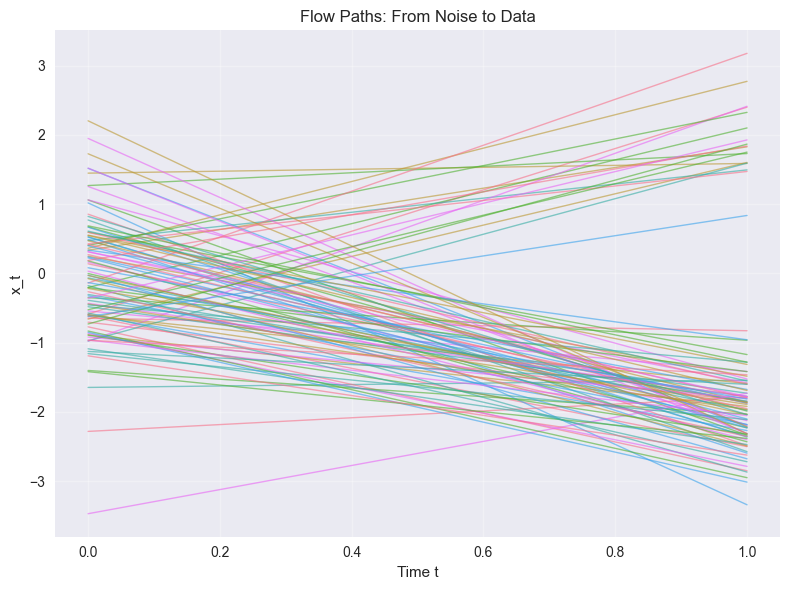

In [3]:
# Visualize flow matching paths
def visualize_flow_paths(flow_matching, target_data, num_paths=100):
    """Visualize individual flow paths from noise to data."""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Sample some target points
    target_samples = np.random.choice(target_data, num_paths, replace=False)
    
    # Sample noise points (from standard Gaussian)
    noise_samples = np.random.normal(0, 1, num_paths)
    
    # Plot flow paths
    t_values = np.linspace(0, 1, 100)
    
    for i in range(num_paths):
        x0 = noise_samples[i]
        x1 = target_samples[i]
        
        # Compute path
        path = (1 - t_values) * x0 + t_values * x1
        
        ax.plot(t_values, path, alpha=0.6, linewidth=1)
    
    ax.set_xlabel('Time t')
    ax.set_ylabel('x_t')
    ax.set_title('Flow Paths: From Noise to Data')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_flow_paths(flow_matching, target_data)

## 5. Learning Neural Networks {#flow-learning}

Now let's implement and train a neural network to learn the velocity field for flow matching.


Training Flow Matching Network...


Training Flow Matching: 100%|█


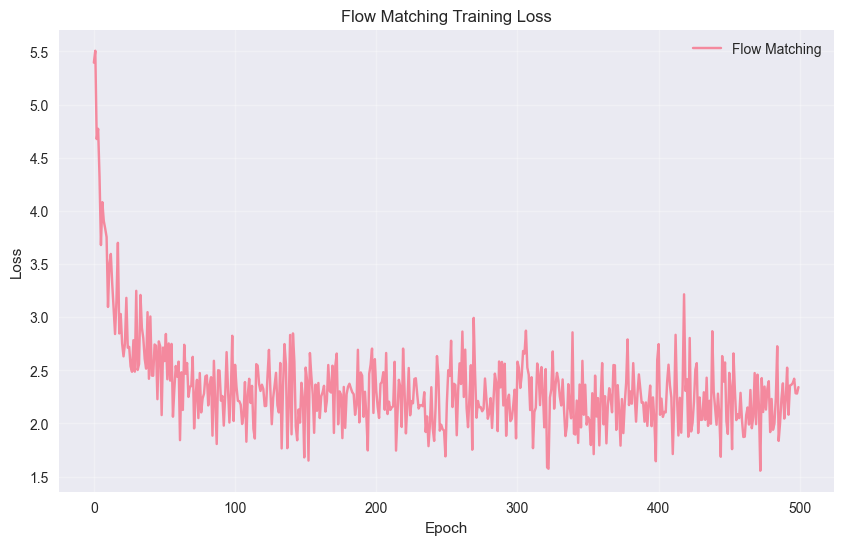

Final Flow Matching Loss: 2.341759


In [4]:
# Neural Network for Flow Matching (Velocity Field)
class FlowMatchingNet(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),  # x and t
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)   # velocity field
        )
    
    def forward(self, x, t):
        # Concatenate x and t
        inputs = torch.cat([x, t], dim=-1)
        return self.net(inputs)

# Training function for flow matching
def train_flow_matching(flow_net, target_data, num_epochs=1000, batch_size=256, lr=1e-3):
    """Train the flow matching network."""
    optimizer = torch.optim.Adam(flow_net.parameters(), lr=lr)
    losses = []
    
    for epoch in tqdm(range(num_epochs), desc="Training Flow Matching"):
        # Sample batch
        batch_indices = np.random.choice(len(target_data), batch_size, replace=False)
        x1 = torch.tensor(target_data[batch_indices], dtype=torch.float32).unsqueeze(-1)
        x0 = torch.randn_like(x1)  # Sample from noise
        
        # Sample random times
        t = torch.rand(batch_size, 1)
        
        # Compute flow path
        x_t = (1 - t) * x0 + t * x1
        v_true = x1 - x0  # True velocity field
        
        # Predict velocity
        v_pred = flow_net(x_t, t)
        
        # Compute loss
        loss = torch.mean((v_pred - v_true) ** 2)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    return losses

# Initialize and train flow matching network
flow_net = FlowMatchingNet()
print("Training Flow Matching Network...")
flow_losses = train_flow_matching(flow_net, target_data, num_epochs=500)

# Visualize training progress
plt.figure(figsize=(10, 6))
plt.plot(flow_losses, label='Flow Matching', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Flow Matching Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final Flow Matching Loss: {flow_losses[-1]:.6f}")

## 6. Examples and Applications {#flow-examples}

Let's test our trained flow matching model on different distributions and see how it performs.


Generating samples from Flow Matching...


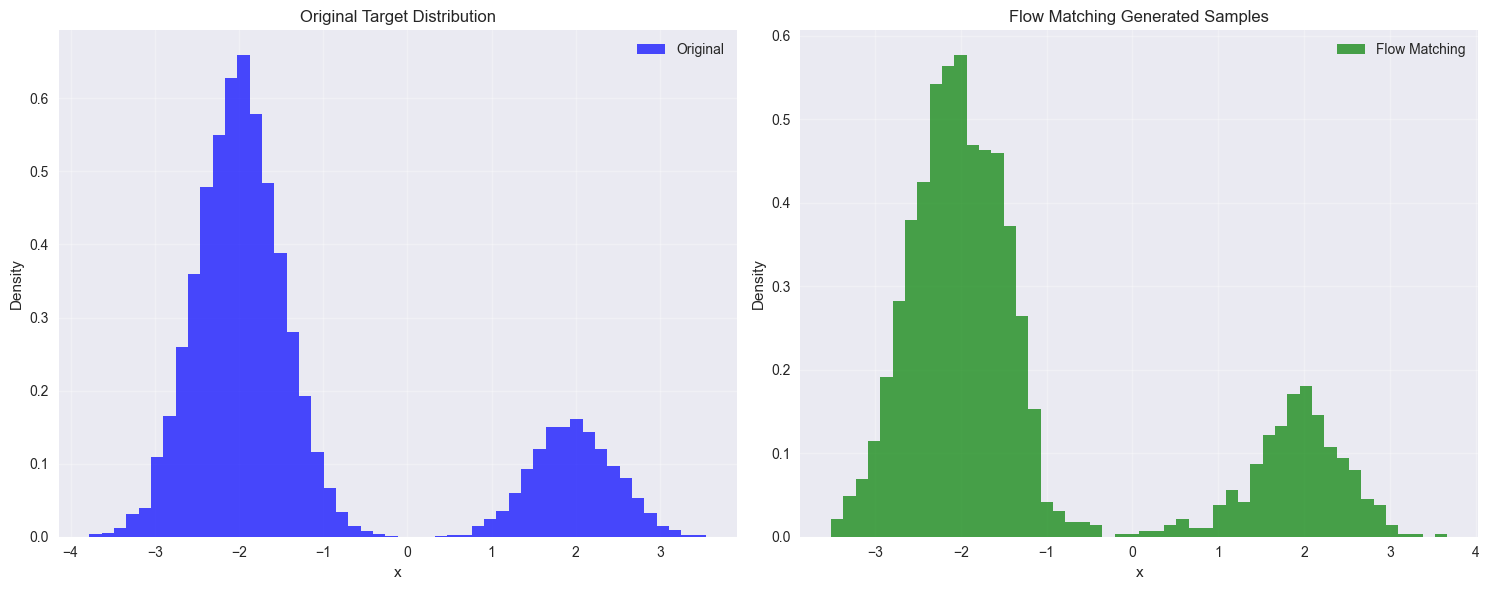

In [100]:
# Sampling function for flow matching
def sample_flow_matching(flow_net, num_samples=1000, num_steps=100):
    """Sample from the flow matching model."""
    flow_net.eval()
    with torch.no_grad():
        # Start from noise
        x = torch.randn(num_samples, 1)
        
        # Integrate the flow (simple Euler integration)
        dt = 1.0 / num_steps
        for i in range(num_steps):
            t = torch.full((num_samples, 1), i * dt)
            v = flow_net(x, t)
            # v = v - 1. * (x - 2)       # Classifer-based guidance
            x = x + v * dt
        
        return x.numpy().flatten()

# Generate samples from flow matching
print("Generating samples from Flow Matching...")
flow_samples = sample_flow_matching(flow_net, num_samples=2000)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Original data
axes[0].hist(target_data, bins=50, alpha=0.7, density=True, color='blue', label='Original')
axes[0].set_title('Original Target Distribution')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Flow matching samples
axes[1].hist(flow_samples, bins=50, alpha=0.7, density=True, color='green', label='Flow Matching')
axes[1].set_title('Flow Matching Generated Samples')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Comparing Ground Truth vs Learned Flow Paths...


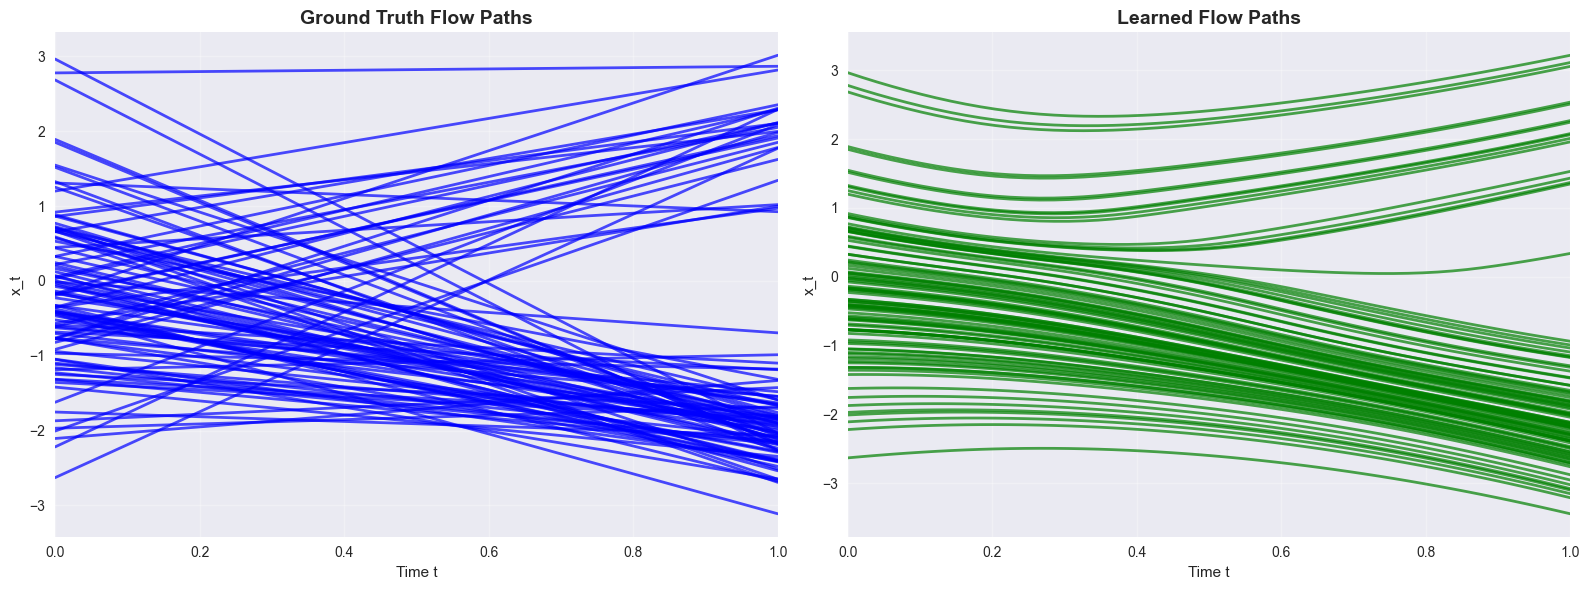

In [6]:
# Compare Ground Truth vs Learned Flow Paths
def compare_flow_paths(flow_net, target_data, num_paths=100):
    """Compare ground truth flow paths with learned flow paths"""
    flow_net.eval()
    
    # Sample some target points and noise points
    target_samples = np.random.choice(target_data, num_paths, replace=False)
    noise_samples = np.random.normal(0, 1, num_paths)
    
    # Time points for visualization
    t_values = np.linspace(0, 1, 50)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: "Ground Truth" Flow Paths
    for i in range(num_paths):
        x0 = noise_samples[i]
        x1 = target_samples[i]
        # Ground truth path: linear interpolation
        ground_truth_path = (1 - t_values) * x0 + t_values * x1
        axes[0].plot(t_values, ground_truth_path, alpha=0.7, linewidth=2, color='blue')
    
    axes[0].set_title('Ground Truth Flow Paths', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Time t')
    axes[0].set_ylabel('x_t')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(0, 1)
    
    # Plot 2: Learned Flow Paths
    with torch.no_grad():
        for i in range(num_paths):
            x0 = noise_samples[i]
            x1 = target_samples[i]
            
            # Start from noise
            x = torch.tensor([[x0]], dtype=torch.float32)
            learned_path = [x0]
            
            # Integrate the learned flow
            dt = 1.0 / (len(t_values) - 1)
            for j in range(1, len(t_values)):
                t = torch.tensor([[t_values[j]]], dtype=torch.float32)
                v = flow_net(x, t)
                x = x + v * dt
                learned_path.append(x.item())
            
            axes[1].plot(t_values, learned_path, alpha=0.7, linewidth=2, color='green')
    
    axes[1].set_title('Learned Flow Paths', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time t')
    axes[1].set_ylabel('x_t')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()

# Run the comparison
print("Comparing Ground Truth vs Learned Flow Paths...")
compare_flow_paths(flow_net, target_data, num_paths=100)


=== Testing Flow Matching on UNIFORM Distribution ===


Training Flow Matching: 100%|█


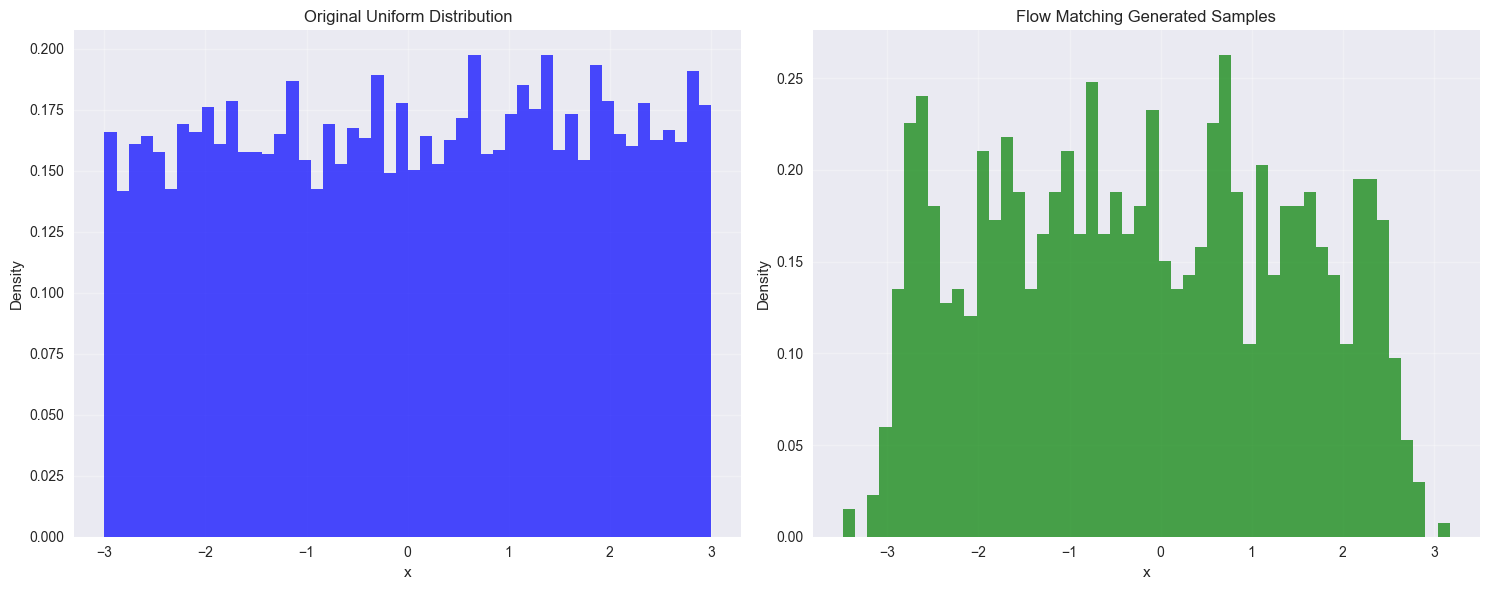

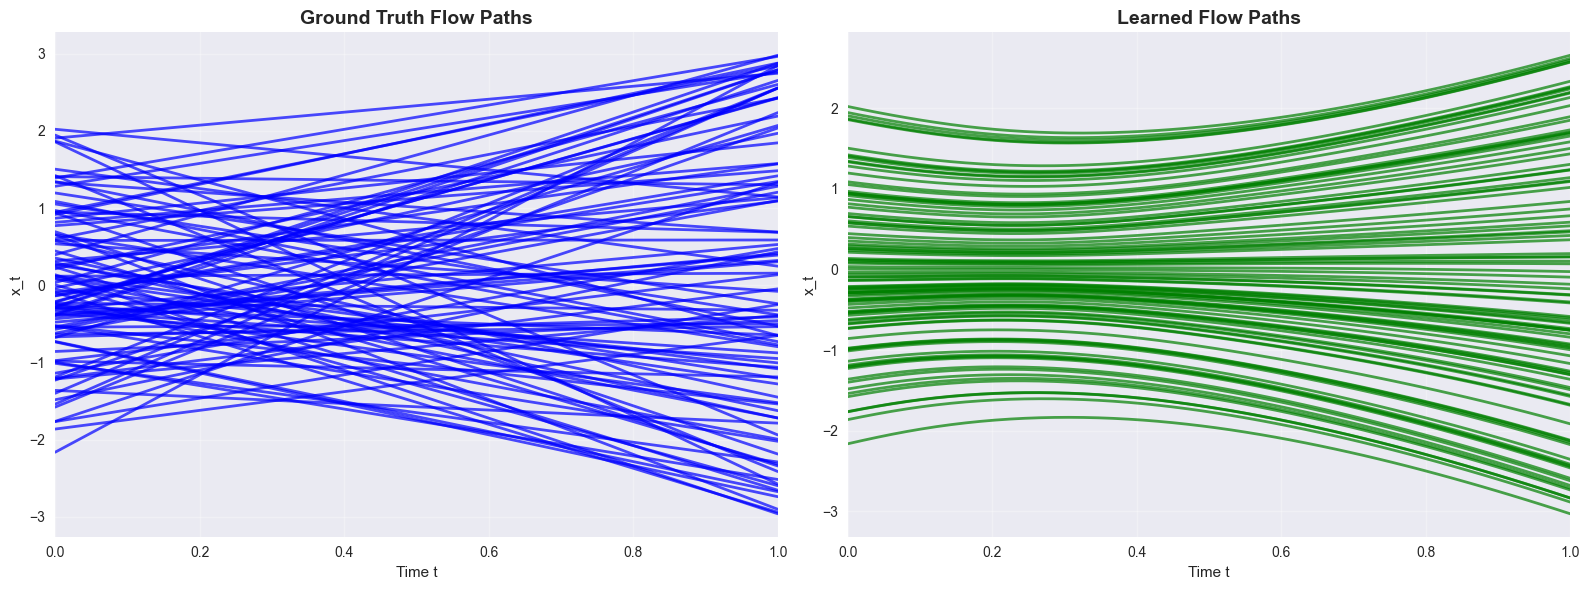

2.693305492401123

In [13]:
# Test on different distributions
def test_flow_matching_on_distribution(distribution_name, distribution_data):
    """Test flow matching on a specific distribution."""
    print(f"\n=== Testing Flow Matching on {distribution_name.upper()} Distribution ===")
    
    # Train a new network on this distribution
    test_flow_net = FlowMatchingNet()
    test_losses = train_flow_matching(test_flow_net, distribution_data, num_epochs=300)
    
    # Generate samples
    test_samples = sample_flow_matching(test_flow_net, num_samples=1000)
    
    # Visualize: Histogram
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    axes[0].hist(distribution_data, bins=50, alpha=0.7, density=True, color='blue')
    axes[0].set_title(f'Original {distribution_name.capitalize()} Distribution')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('Density')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(test_samples, bins=50, alpha=0.7, density=True, color='green')
    axes[1].set_title(f'Flow Matching Generated Samples')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('Density')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Visualize: Flow Paths
    compare_flow_paths(test_flow_net, distribution_data, num_paths=100)
    
    return test_losses[-1]

# Test on uniform distribution
uniform_data = np.random.uniform(-3, 3, 10000)
test_flow_matching_on_distribution('uniform', uniform_data)

# Test on Dirac delta distribution
# dirac_data = np.random.uniform(1-0.001, 1+0.001, 10000)
# test_flow_matching_on_distribution('Dirac delta', dirac_data)

# Chapter 2: Diffusion Models

## 7. Mathematical Foundations {#diffusion-math}

Diffusion models work by gradually adding noise to data and then learning to reverse this process. They have become one of the most successful generative modeling approaches.

### Key Concepts:
- **Forward Process**: Gradually add noise to data until it becomes pure noise
- **Reverse Process**: Learn to remove noise step by step to generate new data
- **Noise Schedule**: Controls how much noise to add at each timestep
- **Denoising**: The core task is to predict and remove noise

Sorry - the convention in diffusion is opposite to flow: $x_0$ is the clean data.

#### Key Equations:

**1. Forward Process (Adding Noise):**
$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t I)$$

**2. Forward Process (Direct from x₀):**
$$q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t) I)$$

where $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$ and $\alpha_t = 1 - \beta_t$

**3. Reverse Process (Denoising):**
$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$

**4. Training Loss (Noise Prediction):**
$$\mathcal{L}_{DDPM} = \mathbb{E}_{t,x_0,\epsilon} \|\epsilon - \epsilon_\theta(x_t, t)\|^2 =  \mathbb{E}_{t,x_0,\epsilon} \|\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon, t)\|^2$$

where $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$

**5. Sampling (DDIM, deterministic):**
$$x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} \hat{x}_0 + \sqrt{1-\bar{\alpha}_{t-1}} \epsilon_\theta(x_t, t)$$

$$\text{where} \quad \hat{x}_0 = \frac{x_t - \sqrt{1 - \bar{\alpha}_t} \epsilon_\theta(x_t, t)} {\sqrt{\bar{\alpha}_t}}$$

**6. Sampling (DDPM, stochastic):**
$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t z$$

### Intuition:
- We learn to predict the noise that was added at each timestep
- The reverse process gradually removes noise to generate clean data
- The noise schedule controls the rate of noise addition/removal


## 8. Visualization {#diffusion-viz}

Let's visualize how the diffusion process works by showing the forward noise addition process.

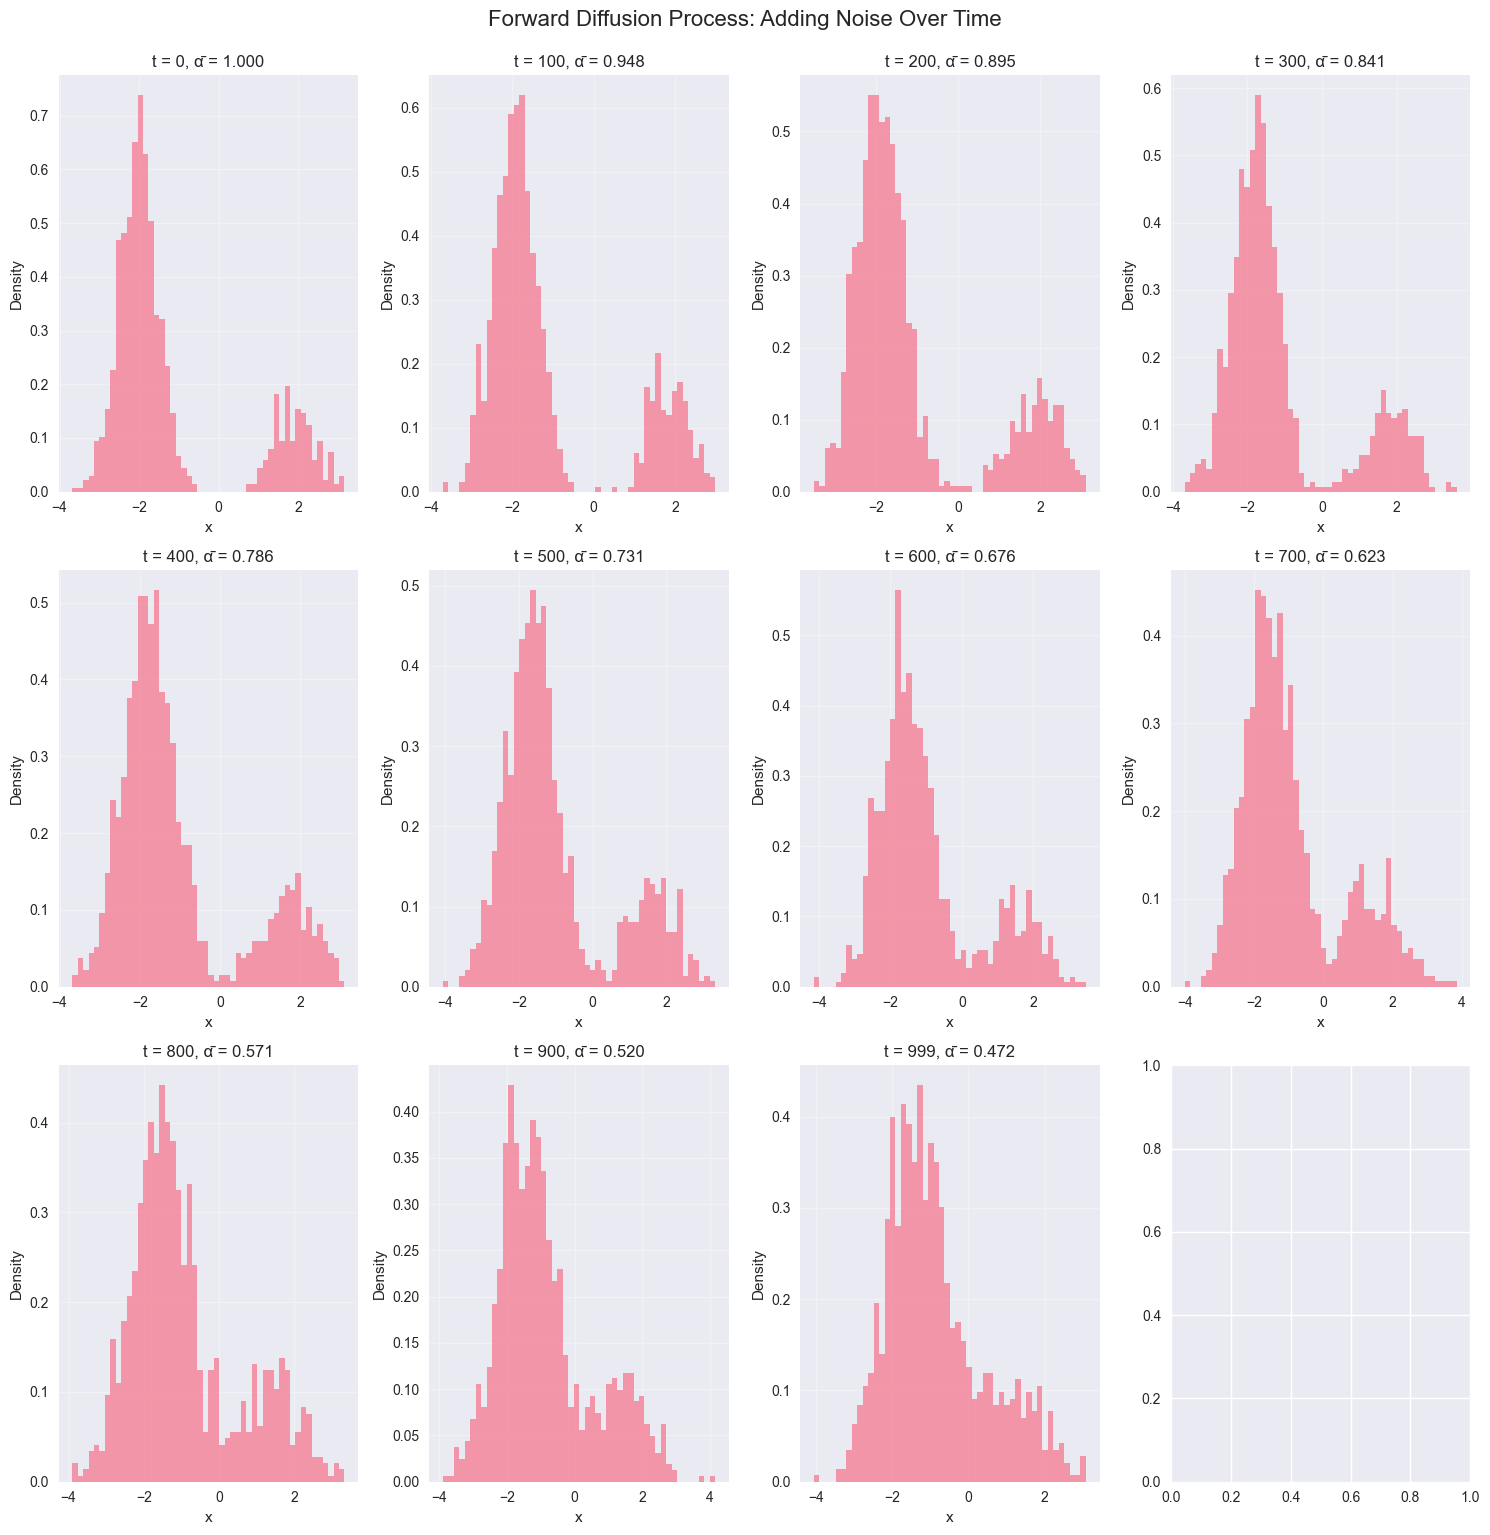

In [86]:
# Cosine beta schedule helper function
def cosine_beta_schedule(T, s=0.008):
    t = np.arange(T+1, dtype=np.float64)
    f = np.cos(((t/T + s) / (1+s)) * np.pi * 0.5)**2
    alpha_bar = f / f[0]
    betas = np.clip(1 - (alpha_bar[1:] / alpha_bar[:-1]), 1e-6, 0.02)
    return betas
    
# Diffusion model implementation
class SimpleDiffusion1D:
    """A simple 1D diffusion model implementation."""
    
    def __init__(self, num_timesteps=1000, beta_start=0.0005, beta_end=0.001, s=0.008):
        self.num_timesteps = num_timesteps
        
        # Define the noise schedule (beta values)
        self.betas = np.linspace(beta_start, beta_end, num_timesteps) # linear beta schedule
        # self.betas = cosine_beta_schedule(num_timesteps, s=0.008)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = np.cumprod(self.alphas)
        
    def forward_process(self, x0, t):
        """Add noise to data according to the forward diffusion process."""
        noise = np.random.normal(0, 1, x0.shape)
        alpha_bar_t = self.alpha_bars[t]
        
        # q(x_t | x_0) = N(x_t; sqrt(alpha_bar_t) * x_0, (1 - alpha_bar_t) * I)
        x_t = np.sqrt(alpha_bar_t) * x0 + np.sqrt(1 - alpha_bar_t) * noise
        return x_t, noise
    
    def sample_timestep(self, batch_size=1000):
        """Sample random timesteps for training."""
        return np.random.randint(0, self.num_timesteps, batch_size)

# Visualize the forward diffusion process
def visualize_forward_diffusion(diffusion, target_data, timesteps_to_show=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]):
    """Visualize how the forward diffusion process gradually adds noise."""
    fig, axes = plt.subplots(3, 4, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, t in enumerate(timesteps_to_show):
        # Sample some data points
        sample_indices = np.random.choice(len(target_data), 1000, replace=False)
        x0_samples = target_data[sample_indices]
        
        # Apply forward diffusion
        x_t, _ = diffusion.forward_process(x0_samples, t)
        
        # Plot
        axes[i].hist(x_t, bins=50, alpha=0.7, density=True)
        axes[i].set_title(f't = {t}, ᾱ = {diffusion.alpha_bars[t]:.3f}')
        axes[i].set_xlabel('x')
        axes[i].set_ylabel('Density')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Forward Diffusion Process: Adding Noise Over Time', y=1.02, fontsize=16)
    plt.show()

# Initialize diffusion model and visualize
diffusion = SimpleDiffusion1D()
visualize_forward_diffusion(diffusion, target_data)

## 9. Learning Neural Networks {#diffusion-learning}

Now let's implement and train a neural network to learn the noise prediction for diffusion models.


Training Diffusion Network...


Training Diffusion: 100%|█| 1000/1000 [00:0


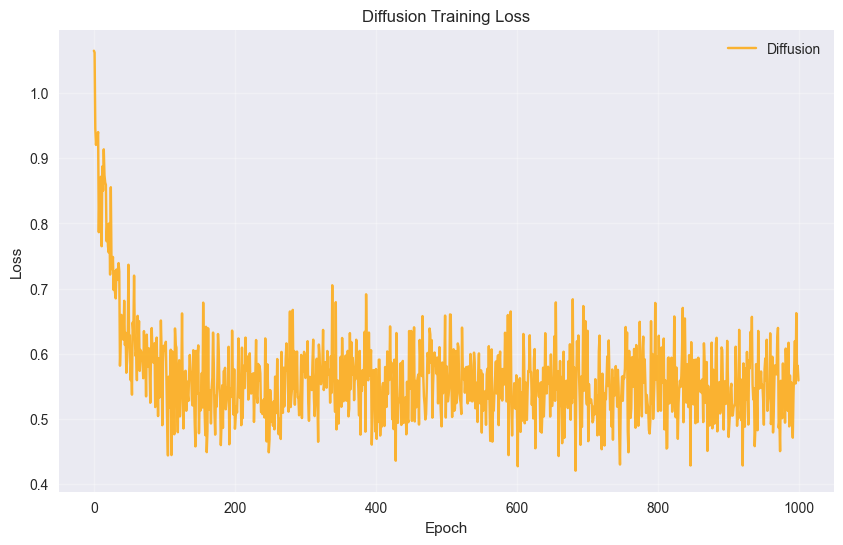

Final Diffusion Loss: 0.558881


In [87]:
# Neural Network for Diffusion (Noise Prediction)
class DiffusionNet(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),  # x and t
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)   # noise prediction
        )
    
    def forward(self, x, t):
        # Concatenate x and t
        inputs = torch.cat([x, t], dim=-1)
        return self.net(inputs)

# Training function for diffusion
def train_diffusion(diffusion_net, target_data, diffusion_model, num_epochs=2000, batch_size=512, lr=5e-4):
    """Train the diffusion network."""
    optimizer = torch.optim.Adam(diffusion_net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    losses = []
    
    for epoch in tqdm(range(num_epochs), desc="Training Diffusion"):
        # Sample batch
        batch_indices = np.random.choice(len(target_data), batch_size, replace=False)
        x0 = torch.tensor(target_data[batch_indices], dtype=torch.float32).unsqueeze(-1)
        
        # Sample random timesteps
        t_indices = np.random.randint(0, diffusion_model.num_timesteps, batch_size)
        t = torch.tensor(t_indices, dtype=torch.float32).unsqueeze(-1) / diffusion_model.num_timesteps
        
        # Apply forward diffusion
        noise = torch.randn_like(x0)
        alpha_bar_t = torch.tensor(diffusion_model.alpha_bars[t_indices], dtype=torch.float32).unsqueeze(-1)
        x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise
        
        # Predict noise
        noise_pred = diffusion_net(x_t, t)
        
        # Compute loss
        loss = torch.mean((noise_pred - noise) ** 2)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
    
    return losses

# Initialize and train diffusion network
diffusion_net = DiffusionNet()
print("Training Diffusion Network...")
diffusion_losses = train_diffusion(diffusion_net, target_data, diffusion, num_epochs=1000)

# Visualize training progress
plt.figure(figsize=(10, 6))
plt.plot(diffusion_losses, label='Diffusion', alpha=0.8, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Diffusion Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final Diffusion Loss: {diffusion_losses[-1]:.6f}")

## 10. Examples and Applications {#diffusion-examples}

Let's test our trained diffusion model and see how it performs on different distributions.


Generating samples from Diffusion...


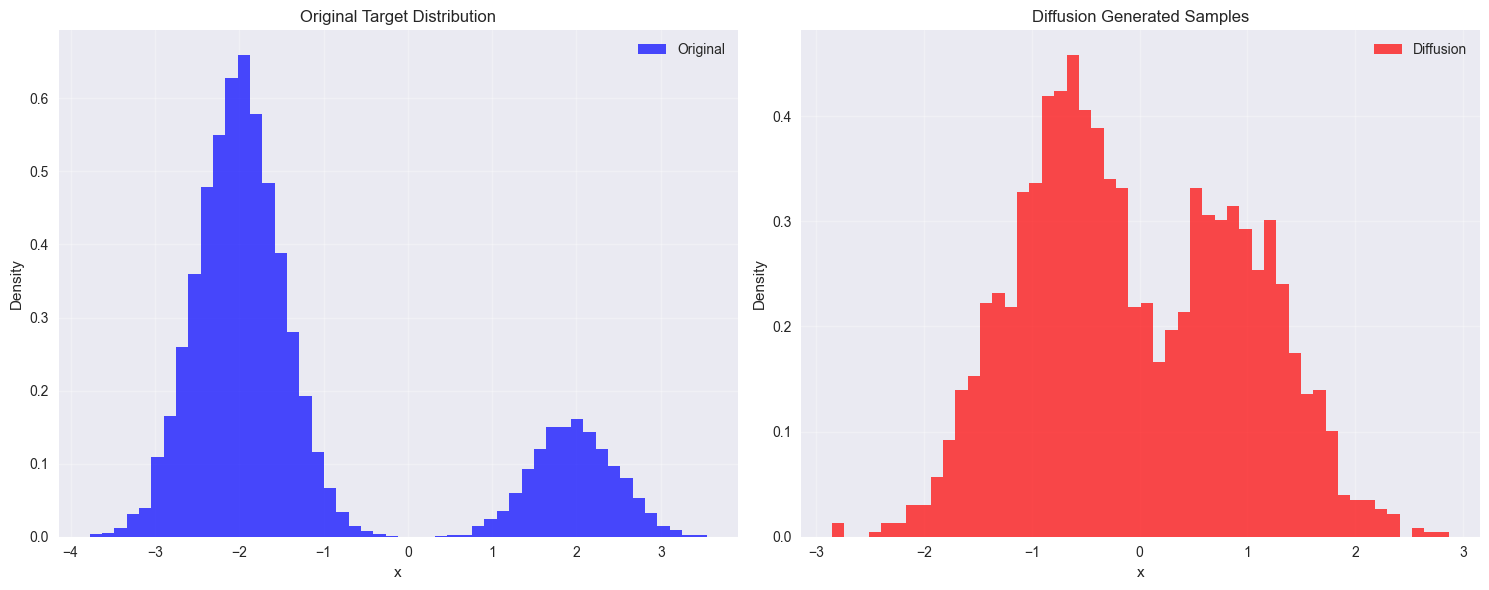

In [88]:
# Sampling function for diffusion (DDIM)
def sample_diffusion(diffusion_net, diffusion_model, num_samples=1000, num_steps=50):
    """Sample from the diffusion model using DDIM."""
    diffusion_net.eval()
    with torch.no_grad():
        # Start from pure noise
        x = torch.randn(num_samples, 1)
        
        # Reverse diffusion
        step_size = diffusion_model.num_timesteps // num_steps
        for i in range(num_steps):
            t_idx = diffusion_model.num_timesteps - 1 - i * step_size
            t = torch.full((num_samples, 1), t_idx / diffusion_model.num_timesteps)
            
            # Predict noise
            noise_pred = diffusion_net(x, t)
            
            # DDIM step
            if t_idx > 0:
                alpha_bar_t = torch.tensor(diffusion_model.alpha_bars[t_idx])
                alpha_bar_prev = torch.tensor(diffusion_model.alpha_bars[t_idx - step_size])

                # Predict x0
                x0_pred = (x - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)
                
                # Sample x_prev
                x = torch.sqrt(alpha_bar_prev) * x0_pred + torch.sqrt(1 - alpha_bar_prev) * noise_pred
            else:
                # Final step
                alpha_bar_t = diffusion_model.alpha_bars[0]
                x = (x - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)
        
        return x.numpy().flatten()

# Generate samples from diffusion
print("Generating samples from Diffusion...")
diffusion_samples = sample_diffusion(diffusion_net, diffusion, num_samples=2000)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Original data
axes[0].hist(target_data, bins=50, alpha=0.7, density=True, color='blue', label='Original')
axes[0].set_title('Original Target Distribution')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Diffusion samples
axes[1].hist(diffusion_samples, bins=50, alpha=0.7, density=True, color='red', label='Diffusion')
axes[1].set_title('Diffusion Generated Samples')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== Testing Diffusion on UNIFORM Distribution ===


Training Diffusion: 100%|█| 300/300 [00:00<


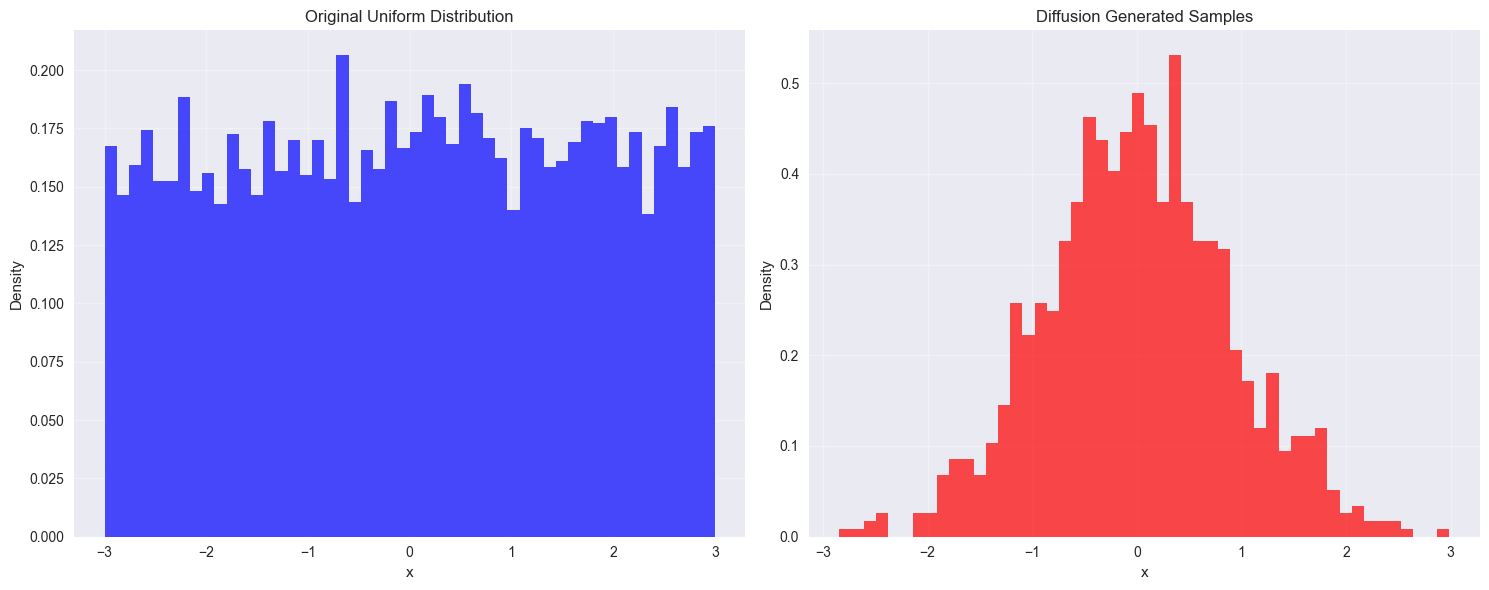

0.7809046506881714

In [91]:
# Test on different distributions
def test_diffusion_on_distribution(distribution_name, distribution_data):
    """Test diffusion on a specific distribution."""
    print(f"\n=== Testing Diffusion on {distribution_name.upper()} Distribution ===")
    
    # Train a new network on this distribution
    test_diffusion_net = DiffusionNet()
    test_losses = train_diffusion(test_diffusion_net, distribution_data, diffusion, num_epochs=300)
    
    # Generate samples
    test_samples = sample_diffusion(test_diffusion_net, diffusion, num_samples=1000)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    axes[0].hist(distribution_data, bins=50, alpha=0.7, density=True, color='blue')
    axes[0].set_title(f'Original {distribution_name.capitalize()} Distribution')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('Density')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(test_samples, bins=50, alpha=0.7, density=True, color='red')
    axes[1].set_title(f'Diffusion Generated Samples')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('Density')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return test_losses[-1]

# Test on uniform distribution
uniform_data = np.random.uniform(-3, 3, 10000)
test_diffusion_on_distribution('uniform', uniform_data)

## 10. DDPM Examples and Applications {#diffusion-examples}

Generating samples from Diffusion...


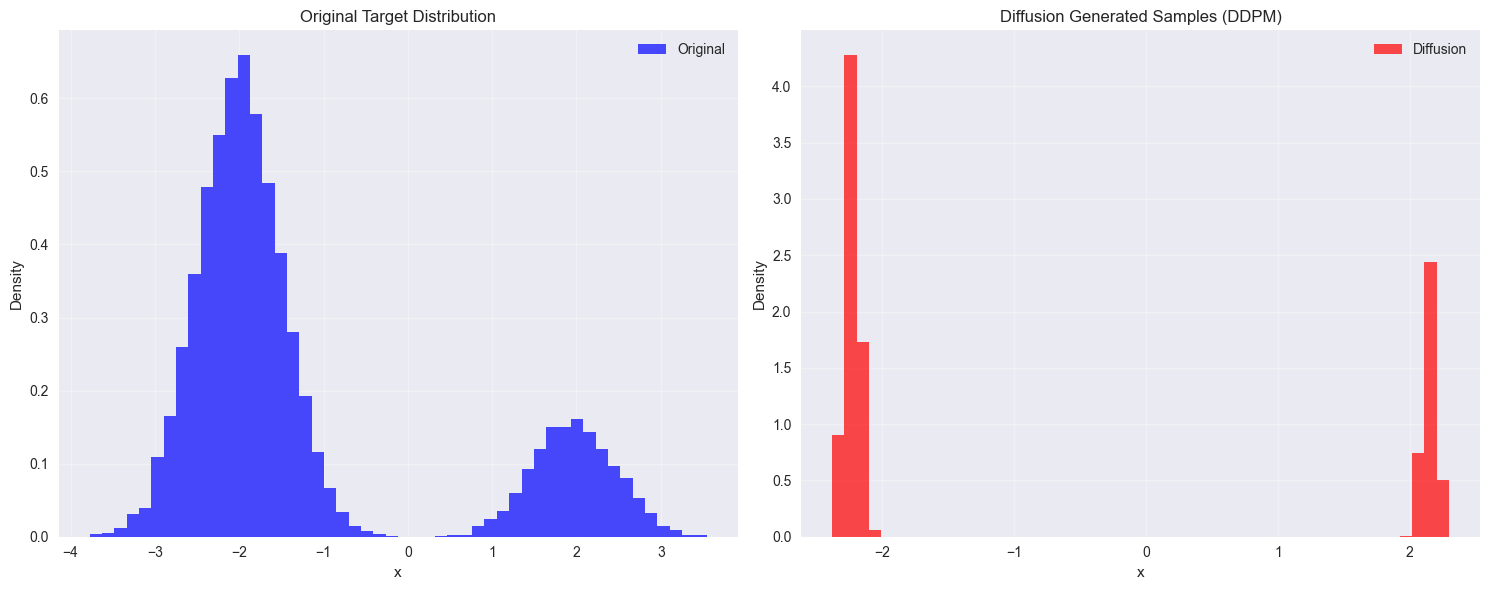

In [92]:
def sample_diffusion_ddpm(diffusion_net, diffusion_model, num_samples=1000, num_steps=100):
    """Use DDPM sampling instead of DDIM for better stability"""
    diffusion_net.eval()
    with torch.no_grad():
        # Start from pure noise
        x = torch.randn(num_samples, 1)
        
        # Reverse diffusion with DDPM
        timesteps = np.linspace(diffusion_model.num_timesteps-1, 0, num_steps, dtype=int)
        
        for i, t_idx in enumerate(timesteps):
            t = torch.full((num_samples, 1), t_idx / diffusion_model.num_timesteps)
            
            # Predict noise
            noise_pred = diffusion_net(x, t)
            
            if i < len(timesteps) - 1:
                # DDPM step
                alpha_t = torch.tensor(diffusion_model.alphas[t_idx])
                beta_t = torch.tensor(diffusion_model.betas[t_idx])
                
                # Predict x0
                alpha_bar_t = torch.tensor(diffusion_model.alpha_bars[t_idx])
                x0_pred = (x - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)
                
                # Add noise for next step
                if i < len(timesteps) - 1:
                    noise = torch.randn_like(x)
                    x = torch.sqrt(alpha_t) * x0_pred + torch.sqrt(1 - alpha_t) * noise
                else:
                    x = x0_pred
            else:
                # Final step
                alpha_bar_t = torch.tensor(diffusion_model.alpha_bars[0])
                x = (x - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)
        
        return x.numpy().flatten()

# Generate samples from diffusion
print("Generating samples from Diffusion...")
diffusion_samples = sample_diffusion_ddpm(diffusion_net, diffusion, num_samples=2000)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Original data
axes[0].hist(target_data, bins=50, alpha=0.7, density=True, color='blue', label='Original')
axes[0].set_title('Original Target Distribution')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Diffusion samples
axes[1].hist(diffusion_samples, bins=50, alpha=0.7, density=True, color='red', label='Diffusion')
axes[1].set_title('Diffusion Generated Samples (DDPM)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Visualizing Diffusion Sampling Trajectories...


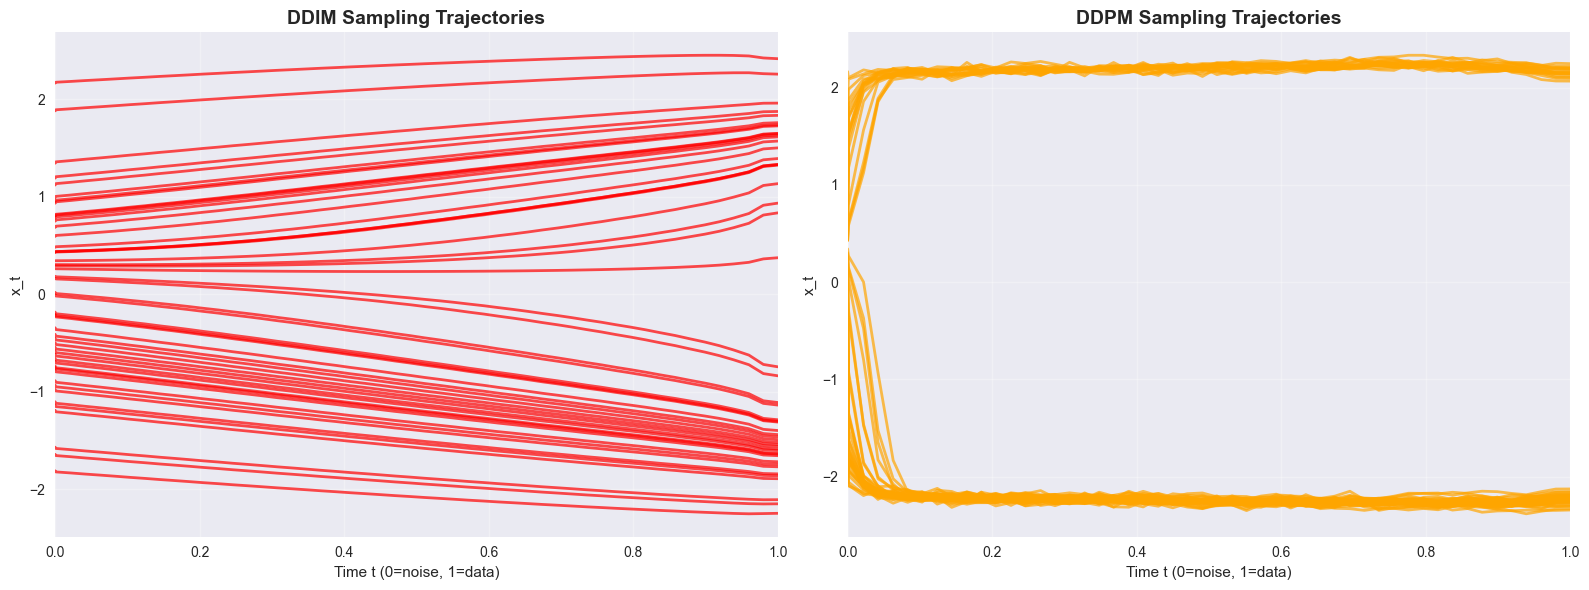

In [93]:
# Visualize Diffusion Trajectories (DDIM and DDPM)
def visualize_diffusion_trajectories(diffusion_net, diffusion_model, target_data, num_trajectories=10):
    """Visualize diffusion sampling trajectories for DDIM and DDPM"""
    diffusion_net.eval()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Sample some starting noise points
    noise_samples = np.random.normal(0, 1, num_trajectories)
    
    # DDIM Trajectories
    with torch.no_grad():
        for i in range(num_trajectories):
            # Start from noise
            x = torch.tensor([[noise_samples[i]]], dtype=torch.float32)
            trajectory = [x.item()]
            times = [0]
            
            # DDIM sampling
            num_steps = 50
            timesteps = np.linspace(diffusion_model.num_timesteps-1, 0, num_steps, dtype=int)
            
            for j, t_idx in enumerate(timesteps):
                t = torch.tensor([[t_idx / diffusion_model.num_timesteps]], dtype=torch.float32)
                
                # Predict noise
                noise_pred = diffusion_net(x, t)
                
                if j < len(timesteps) - 1:
                    # DDIM step
                    alpha_bar_t = torch.tensor(diffusion_model.alpha_bars[t_idx])
                    alpha_bar_prev = torch.tensor(diffusion_model.alpha_bars[timesteps[j+1]])
                    
                    # Predict x0
                    x0_pred = (x - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)
                    
                    # Sample x_prev
                    x = torch.sqrt(alpha_bar_prev) * x0_pred + torch.sqrt(1 - alpha_bar_prev) * noise_pred
                else:
                    # Final step
                    alpha_bar_t = torch.tensor(diffusion_model.alpha_bars[0])
                    x = (x - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)
                
                trajectory.append(x.item())
                times.append((diffusion_model.num_timesteps - t_idx) / diffusion_model.num_timesteps)
            
            # Plot trajectory
            axes[0].plot(times, trajectory, alpha=0.7, linewidth=2, color='red')
    
    axes[0].set_title('DDIM Sampling Trajectories', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Time t (0=noise, 1=data)')
    axes[0].set_ylabel('x_t')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(0, 1)
    
    # DDPM Trajectories
    with torch.no_grad():
        for i in range(num_trajectories):
            # Start from noise
            x = torch.tensor([[noise_samples[i]]], dtype=torch.float32)
            trajectory = [x.item()]
            times = [0]
            
            # DDPM sampling
            num_steps = 50
            timesteps = np.linspace(diffusion_model.num_timesteps-1, 0, num_steps, dtype=int)
            
            for j, t_idx in enumerate(timesteps):
                t = torch.tensor([[t_idx / diffusion_model.num_timesteps]], dtype=torch.float32)
                
                # Predict noise
                noise_pred = diffusion_net(x, t)
                
                if j < len(timesteps) - 1:
                    # DDPM step
                    alpha_t = torch.tensor(diffusion_model.alphas[t_idx])
                    alpha_bar_t = torch.tensor(diffusion_model.alpha_bars[t_idx])
                    
                    # Predict x0
                    x0_pred = (x - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)
                    
                    # Add noise for next step
                    noise = torch.randn_like(x)
                    x = torch.sqrt(alpha_t) * x0_pred + torch.sqrt(1 - alpha_t) * noise
                else:
                    # Final step
                    alpha_bar_t = torch.tensor(diffusion_model.alpha_bars[0])
                    x = (x - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)
                
                trajectory.append(x.item())
                times.append((diffusion_model.num_timesteps - t_idx) / diffusion_model.num_timesteps)
            
            # Plot trajectory
            axes[1].plot(times, trajectory, alpha=0.7, linewidth=2, color='orange')
    
    axes[1].set_title('DDPM Sampling Trajectories', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time t (0=noise, 1=data)')
    axes[1].set_ylabel('x_t')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()

# Run the visualization
print("Visualizing Diffusion Sampling Trajectories...")
visualize_diffusion_trajectories(diffusion_net, diffusion, target_data, num_trajectories=50)

# Chapter 3: Comparison

## 11. Comparison and Analysis {#comparison}

Now let's compare both approaches side by side and understand their differences.

### Key Differences:

| Aspect | Flow Matching | Diffusion Models |
|--------|---------------|------------------|
| **Time** | Continuous time | Discrete timesteps |
| **Process** | Direct flow paths | Add noise → Remove noise |
| **Training** | Predict velocity field | Predict noise at each step |
| **Sampling** | Fewer steps possible | Many steps required |
| **Complexity** | More efficient | Higher computational cost |
| **Mathematical Foundation** | Optimal transport | Stochastic differential equations |
